# 미니 프로젝트 : 가위바위보 분류기를 만들자
작성자: 지동현

In [2]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


### 데이터 불러오기 + Resize 하기
현재 저장된 이미지 사이즈는 224x224이므로 숫자 손글씨 이미지와 같이 크기를 28x28로 resize한다.

In [3]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [4]:
# 사이즈 변경 함수 정의하기
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [5]:
# 바위도 똑같이 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [6]:
# 보도 똑같이 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


### load_data() 함수 만들기
숫자 손글씨 인식기는 mnist.load_data() 라는 함수로 데이터를 읽었던 것처럼 가위바위보도 또한 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수를 만들어야 한다.

In [7]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합: 300
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


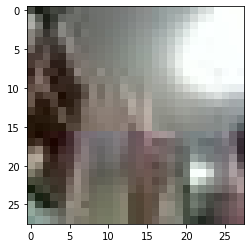

In [9]:
# 이미지 불러오기
import matplotlib.pyplot as plt

plt.imshow(x_train[1])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3))) # 색상: 컬러
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 3클래스

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

### 딥러닝 네트워크 학습시키기

In [11]:
# model.compile()과 model.fit()을 사용

x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=20)

Epoch 1/20
10/10 [==============================] - 1s 20ms/step - loss: 1.1161 - accuracy: 0.3200
Epoch 2/20
10/10 [==============================] - 0s 18ms/step - loss: 1.1025 - accuracy: 0.3467
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 1.0990 - accuracy: 0.3367
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 1.0973 - accuracy: 0.3600
Epoch 5/20
10/10 [==============================] - 0s 17ms/step - loss: 1.0923 - accuracy: 0.3333
Epoch 6/20
10/10 [==============================] - 0s 18ms/step - loss: 1.0873 - accuracy: 0.3900
Epoch 7/20
10/10 [==============================] - 0s 18ms/step - loss: 1.0825 - accuracy: 0.6867
Epoch 8/20
10/10 [==============================] - 0s 17ms/step - loss: 1.0768 - accuracy: 0.4833
Epoch 9/20
10/10 [==============================] - 0s 20ms/step - loss: 1.0695 - accuracy: 0.4200
Epoch 10/20
10/10 [==============================] - 0s 19ms/step - loss: 1.0571 - accuracy: 0.6000
Epoch 11/

### 얼마나 잘 만들었는지 확인하기(테스트)
우선 다른 그루분의 이미지 데이터 300장을 받아와 테스트 데이터로 사용해보았다.(# 김연님 이미지)

In [12]:
# 가위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

# 바위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

# 보
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


### 위에서 훈련시킨 model을 사용하여 test_accuracy를 측정

In [13]:
# model.evaluate()을 사용
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)

test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.4647 - accuracy: 0.5900
test_loss: 2.464661121368408
test_accuracy: 0.5899999737739563


## 모델이 더 잘 예측할 수 있도록 train data를 추가 (Upgrade_train)
train data: paper(824장) / rock(814) / scissor(814장) / 총 2452장


In [15]:
# resizing

#가위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/scissor"
resize_images(image_dir_path)

# 바위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/rock"
resize_images(image_dir_path)

# 보
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/paper"
resize_images(image_dir_path)


814  images to be resized.
814  images resized.
814  images to be resized.
814  images resized.
824  images to be resized.
824  images resized.


In [17]:
# train 데이터 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train"
(x_train, y_train)=load_data(image_dir_path, number_of_data=2452) # 총 이미지 개수 반영!!
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2452 입니다.
x_train shape: (2452, 28, 28, 3)
y_train shape: (2452,)


Epoch 1/30
62/62 [==============================] - 2s 24ms/step - loss: 1.0246 - accuracy: 0.4518 - val_loss: 1.6837 - val_accuracy: 0.0000e+00
Epoch 2/30
62/62 [==============================] - 1s 22ms/step - loss: 0.9186 - accuracy: 0.5987 - val_loss: 1.5640 - val_accuracy: 0.0000e+00
Epoch 3/30
62/62 [==============================] - 1s 23ms/step - loss: 0.7908 - accuracy: 0.6466 - val_loss: 1.3786 - val_accuracy: 0.2505
Epoch 4/30
62/62 [==============================] - 1s 23ms/step - loss: 0.6517 - accuracy: 0.7063 - val_loss: 1.6490 - val_accuracy: 0.2057
Epoch 5/30
62/62 [==============================] - 1s 22ms/step - loss: 0.5683 - accuracy: 0.7506 - val_loss: 1.0724 - val_accuracy: 0.3910
Epoch 6/30
62/62 [==============================] - 1s 22ms/step - loss: 0.4826 - accuracy: 0.8016 - val_loss: 1.0178 - val_accuracy: 0.5438
Epoch 7/30
62/62 [==============================] - 1s 22ms/step - loss: 0.3992 - accuracy: 0.8506 - val_loss: 0.9316 - val_accuracy: 0.5845
Epoch

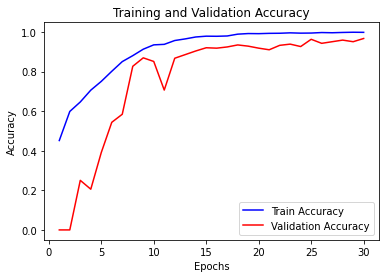

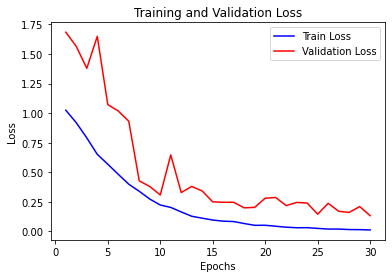

In [45]:
# 모델 학습

# 모델 초기화
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3))) # 색상: 컬러
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train_reshaped, y_train, validation_split=0.2, epochs=30)

# 훈련 데이터와 검증 데이터에 대한 정확도
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 데이터와 검증 데이터에 대한 손실
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 그래프 그리기
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# test (이번에는 jupyter cloud내 data 폴더에 있는 이미지를 test용으로 사용해 보았다)

# 가위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/test/scissor"
resize_images(image_dir_path)

# 바위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/test/rock"
resize_images(image_dir_path)

# 보
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/upgrade_train/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [46]:
x_test_reshaped=x_test_norm.reshape(-1, 28, 28, 3)

test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 7.5761 - accuracy: 0.4533
test_loss: 7.576074123382568
test_accuracy: 0.4533333480358124


# 회고

- 모델 학습 시 loss 값이 0.3xxxx, 0.4xxxx 와 같이 그렇게 낮은 수치가 아닌데도 불구하고 정확도가 상당히 높게 나왔었다. 이는 가위나 바위, 보가 서로 엇비슷하게 보이지만 그래도 정답에 해당하는 클래스가 다른 두 클래스에 비해 확률은 더 높게 나온 경우가 많다는 뜻으로 이해하였다.


- 오버피팅을 극복하기 위해 추가로 6명의 그루분의 데이터를 받아 다양성을 높이고자 하였지만 오히려 처음 데이터셋 300장으로 테스트한 결과가 더 좋게 나오는 아이러니한 상황이 발생하였다...


- 오버피팅이 되지 않는 선에서 epoch 수를 조정하고자 epoch에 따른 accuracy 및 loss 값을 그래프로 도식화하여 적정한 epoch를 선정하였지만 여전히 50%를 넘기지는 못하였다.


- 학습 과정에서는 정확도가 우수하게 나온데에 반해 모델을 테스트하기 위해 evaluate한 결과 그 차이가 너무나 커서 당황하지 않을 수가 없었다. 데이터 셋의 수가 많아졌지만 아무래도 더 많고 다양한 데이터 셋이 필요한 것으로 보인다.

- 이미지를 resizing한 후 imgshow로 확인해 보니 알아보기 힘들 정도로 이미지가 깨져있었는데 그것 때문에 더 판별하기 어려워진 것이 아닐까? 굳이 224x224크기를 28x28로 사이즈 조정을 할 필요가 있었을까?라는 의문이 들었다.
